# Interplanetary Trajectory Optimization

## Problem Overview
The goal is to transfer a spacecraft from Earth's orbit to Jupiter's orbit, minimizing the total transfer time. The spacecraft uses a low-thrust propulsion system, and the trajectory is optimized to satisfy physical constraints.

---

## States
1. **Radial Distance (\(r\))**:
   - Description: Distance from the Sun.
   - Units: Astronomical Units (AU).

2. **Radial Velocity (\(v_r\))**:
   - Description: Velocity in the radial direction (towards/away from the Sun).
   - Units: AU/year.

3. **Tangential Velocity (\(v_t\))**:
   - Description: Velocity perpendicular to the radial direction (orbital velocity).
   - Units: AU/year.

4. **Mass (\(m\))**:
   - Description: Spacecraft mass.
   - Units: Arbitrary units (normalized).

---

## Controls
1. **Thrust Magnitude (\(T\))**:
   - Description: Thrust as a fraction of the maximum available thrust.
   - Range: \(0 \leq T \leq T_{\text{max}}\).
   - Units: Arbitrary units (normalized).

2. **Thrust Angle (\(\beta\))**:
   - Description: Direction of thrust with respect to the radial direction.
   - Range: \(-\pi \leq \beta \leq \pi\).
   - Units: Radians.

---

## Dynamics
The system dynamics are governed by the following equations of motion:

1. **Radial Distance**:
   \[
   \dot{r} = v_r
   \]

2. **Radial Velocity**:
   \[
   \dot{v_r} = \frac{T}{m} \cos(\beta) - \frac{\mu}{r^2} + \frac{v_t^2}{r}
   \]

3. **Tangential Velocity**:
   \[
   \dot{v_t} = \frac{T}{m} \sin(\beta) - \frac{v_r v_t}{r}
   \]

4. **Mass**:
   \[
   \dot{m} = -\frac{T}{I_{sp} g_0}
   \]

Where:
- \(\mu = 1\) AU\(^3\)/year\(^2\): Gravitational parameter of the Sun.
- \(I_{sp}\): Specific impulse.
- \(g_0\): Gravitational acceleration.

---

## Constraints

### Initial Conditions
1. \(r = 1.0\) AU (Earth's orbit).
2. \(v_r = 0.0\) AU/year.
3. \(v_t = 1.0\) AU/year.
4. \(m = 1.0\) unit.

### Final Conditions
1. \(r = 5.2\) AU (Jupiter's orbit).
2. \(v_r = 0.0\) AU/year.
3. \(v_t = \sqrt{\mu / r} = \sqrt{1 / 5.2}\) AU/year.

### Thrust Bounds
1. \(0 \leq T \leq T_{\text{max}} = 0.01\) unit.

### Thrust Angle Bounds
1. \(-\pi \leq \beta \leq \pi\).

### Time Bounds
1. \(0 \leq t_f \leq 20\) years.

---

## Objective
Minimize the total transfer time (\(t_f\)):
\[
J = t_f
\]


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from OpenGoddard.optimize import Problem, Guess, Condition, Dynamics

In [3]:
class InterplanetaryTrajectory:
    def __init__(self):
        self.mu = 1.0  # Gravitational parameter of the Sun (AU^3/yr^2)
        self.r0 = 1.0  # Earth's orbit (AU)
        self.vr0 = 0.0  # Initial radial velocity
        self.vt0 = 1.0  # Initial tangential velocity (AU/yr)
        self.rf = 5.2  # Jupiter's orbit (AU)
        self.vrf = 0.0  # Final radial velocity
        self.vtf = np.sqrt(self.mu / self.rf)  # Final tangential velocity (AU/yr)
        self.m0 = 1.0  # Initial mass
        self.tf_max = 20  # Maximum time for transfer (years)

In [4]:
def dynamics(prob, obj, section):
    """
    Defines the dynamics of the interplanetary trajectory problem.
    
    Parameters:
    - prob: Problem instance containing the optimization problem.
    - obj: InterplanetaryTrajectory instance containing problem parameters.
    - section: Section index for the problem.
    
    Returns:
    - dx: Dynamics object containing the state derivatives.
    """
    r = prob.states(0, section)
    vr = prob.states(1, section)
    vt = prob.states(2, section)
    m = prob.states(3, section)
    T = prob.controls(0, section)
    beta = prob.controls(1, section)

    dx = Dynamics(prob, section)
    dx[0] = vr  # dr/dt = radial velocity
    dx[1] = T / m * np.cos(beta) - obj.mu / r**2 + vt**2 / r  # dv_r/dt
    dx[2] = T / m * np.sin(beta) - vr * vt / r  # dv_t/dt
    dx[3] = -T  # dm/dt (assuming normalized thrust to maximum possible)
    return dx()

In [5]:
def equality(prob, obj):
    """
    Defines the equality constraints for the optimization problem.
    
    Parameters:
    - prob: Problem instance containing the optimization problem.
    - obj: InterplanetaryTrajectory instance containing problem parameters.
    
    Returns:
    - result: Condition object containing the equality constraints.
    """
    r = prob.states_all_section(0)
    vr = prob.states_all_section(1)
    vt = prob.states_all_section(2)
    m = prob.states_all_section(3)

    result = Condition()

    # Initial conditions
    result.equal(r[0], obj.r0)
    result.equal(vr[0], obj.vr0)
    result.equal(vt[0], obj.vt0)
    result.equal(m[0], obj.m0)

    # Final conditions
    result.equal(r[-1], obj.rf)
    result.equal(vr[-1], obj.vrf)
    result.equal(vt[-1], obj.vtf)

    return result()

In [6]:
def inequality(prob, obj):
    """
    Defines the inequality constraints for the optimization problem.
    
    Parameters:
    - prob: Problem instance containing the optimization problem.
    - obj: InterplanetaryTrajectory instance containing problem parameters.
    
    Returns:
    - result: Condition object containing the inequality constraints.
    """
    T = prob.controls_all_section(0)
    beta = prob.controls_all_section(1)
    r = prob.states_all_section(0)
    tf = prob.time_final(-1)

    result = Condition()

    # Bounds on thrust
    result.lower_bound(T, 0.0)
    result.upper_bound(T, 0.01)  # Maximum thrust fraction

    # Bounds on thrust angle
    result.lower_bound(beta, -np.pi)
    result.upper_bound(beta, np.pi)

    # Bounds on radial distance
    result.lower_bound(r, obj.r0)
    result.upper_bound(r, obj.rf)

    # Time bounds
    result.lower_bound(tf, 0.0)
    result.upper_bound(tf, obj.tf_max)

    return result()

In [7]:
def cost(prob, obj):
    """
    Defines the cost function for the optimization problem.
    
    Parameters:
    - prob: Problem instance containing the optimization problem.
    - obj: InterplanetaryTrajectory instance containing problem parameters.
    
    Returns:
    - Cost value to be minimized (final time).
    """
    return prob.time_final(-1)  # Minimize time

In [8]:
def running_cost(prob, obj):
    """
    Defines the running cost for the optimization problem.
    
    Parameters:
    - prob: Problem instance containing the optimization problem.
    - obj: InterplanetaryTrajectory instance containing problem parameters.
    
    Returns:
    - Running cost value (constant 1.0).
    """
    return 1.0  # Running cost

In [ ]:
# Problem setup
time_init = [0.0, 10.0]
n = [100]
num_states = [4]  # r, vr, vt, m
num_controls = [2]  # T, beta
max_iteration = 10

# Initialize problem
prob = Problem(time_init, n, num_states, num_controls, max_iteration)
obj = InterplanetaryTrajectory()

# Initial guess
r_guess = Guess.linear(prob.time_all_section, obj.r0, obj.rf)
vr_guess = Guess.linear(prob.time_all_section, obj.vr0, obj.vrf)
vt_guess = Guess.linear(prob.time_all_section, obj.vt0, obj.vtf)
m_guess = Guess.linear(prob.time_all_section, obj.m0, obj.m0 * 0.9)
T_guess = Guess.linear(prob.time_all_section, 0.01, 0.01)
beta_guess = Guess.linear(prob.time_all_section, 0.0, 0.0)

prob.set_states_all_section(0, r_guess)
prob.set_states_all_section(1, vr_guess)
prob.set_states_all_section(2, vt_guess)
prob.set_states_all_section(3, m_guess)
prob.set_controls_all_section(0, T_guess)
prob.set_controls_all_section(1, beta_guess)

# Assign problem functions
prob.dynamics = [dynamics]
prob.cost = cost
prob.running_cost = running_cost
prob.equality = equality
prob.inequality = inequality

# Solve the problem
prob.solve(obj)


---- iteration : 1 ----


In [ ]:

# Post-process results
r = prob.states_all_section(0)
vr = prob.states_all_section(1)
vt = prob.states_all_section(2)
m = prob.states_all_section(3)
T = prob.controls_all_section(0)
beta = prob.controls_all_section(1)
time = prob.time_update()


---- iteration : 1 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 21.9999999915955
            Iterations: 25
            Function evaluations: 15050
            Gradient evaluations: 25
Iteration limit reached

---- iteration : 2 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 21.999999999705157
            Iterations: 25
            Function evaluations: 15050
            Gradient evaluations: 25
Iteration limit reached

---- iteration : 3 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 22.000000012146145
            Iterations: 25
            Function evaluations: 15051
            Gradient evaluations: 25
Iteration limit reached

---- iteration : 4 ----
Iteration limit reached    (Exit mode 9)
            Current function value: 22.000000025482972
            Iterations: 25
            Function evaluations: 15052
            Gradient evaluations: 25
Iteration limit reached

---- i

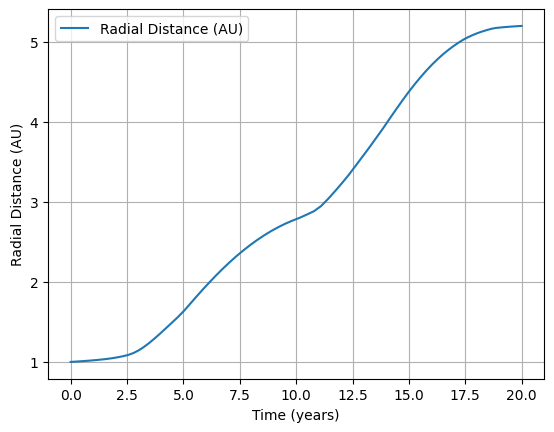

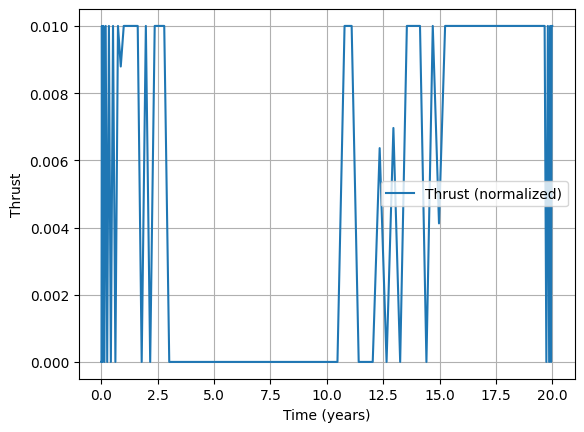

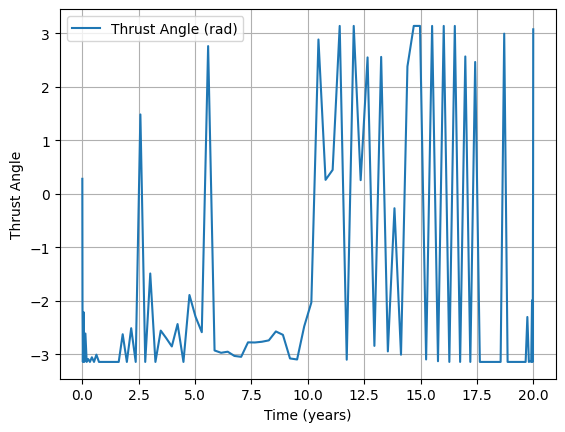

In [ ]:


# Plot results
plt.figure()
plt.plot(time, r, label="Radial Distance (AU)")
plt.xlabel("Time (years)")
plt.ylabel("Radial Distance (AU)")
plt.grid()
plt.legend()

plt.figure()
plt.plot(time, T, label="Thrust (normalized)")
plt.xlabel("Time (years)")
plt.ylabel("Thrust")
plt.grid()
plt.legend()

plt.figure()
plt.plot(time, beta, label="Thrust Angle (rad)")
plt.xlabel("Time (years)")
plt.ylabel("Thrust Angle")
plt.grid()
plt.legend()

plt.show()
